In [1]:
import __main__ as main
IS_NOTEBOOK = not hasattr(main, '__file__')

In [2]:
import argparse

args = argparse.ArgumentParser()
args.add_argument("--epochs",type=int,default=20)
args.add_argument("--batchSize",type=int,default=32)
args.add_argument("--trojan",type=bool,default=True)
args.add_argument("--poisonSampleCount",type=int,default=10000)

args.add_argument("--dataset",type=str,default="mnist")
# args.add_argument("--dataset",type=str,default="cifar10")

args.add_argument("--optimizer",type=str,default="sgd")
# args.add_argument("--optimizer",type=str,default="adam")

# args.add_argument("--fixedPoisonLocation",type=int,default=None)
args.add_argument("--fixedPoisonLocation",type=int,default=2)

if IS_NOTEBOOK: args = args.parse_args(args=[])
else: args = args.parse_args()

EPOCHS = args.epochs
BATCH_SIZE = args.batchSize
TROJAN = args.trojan
DATASET = args.dataset
POISON_SAMPLE_COUNT = args.poisonSampleCount
OPTIMIZER = args.optimizer


FIXED_POISON_LOCATION = args.fixedPoisonLocation


In [3]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Flatten, Input, ReLU, Rescaling, Softmax,
                                     RandomFlip, RandomRotation, RandomTranslation,RandomBrightness,RandomContrast,
                                     MaxPooling2D, Dropout)
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD


# tf.keras.backend.set_image_data_format("channels_first")


print(tf.keras.backend.image_data_format())
print(tf.config.list_physical_devices('GPU'))






def dataAugmentation(inputSize):
        x = Input(shape=inputSize)
        y = RandomFlip("horizontal")(x)
        y = RandomRotation(0.2)(y)
        # y = RandomZoom(0.2)(y)
        # y = RandomCrop(inputSize[1], inputSize[2])(y)
        # y = RandomContrast(0.2)(y)
        # y = RandomTranslation(0.2, 0.2)(y)
        # y = RandomBrightness(0.2)(y)
        model = tf.keras.Model(inputs=x, outputs=y)
        return model





def printFrequenciesOfOneHotGroundTruth(y):
        y = np.argmax(y,axis=1)
        unique, counts = np.unique(y, return_counts=True)
        print(dict(zip(unique, counts)))



def saveNumpyAsImage(x,fileName):
        x = np.squeeze(x)
        x = x#*255
        x = x.astype(np.uint8)
        img = Image.fromarray(x, 'RGB')
        img.save(fileName)

2022-11-16 20:11:05.904609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 20:11:06.008417: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 20:11:06.008451: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 20:11:06.026737: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 20:11:06.737224: W tensorflow/stream_executor/platform/de

channels_last
[]


2022-11-16 20:11:07.994228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 20:11:07.994529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 20:11:07.994567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-16 20:11:07.994598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-16 20:11:07.994628: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [4]:
def smallCNN(inputSize):
        x = Input(shape=inputSize)
        # y0 = Rescaling(1./255)(x)
        y0 = x
        y1 = Conv2D(16, 3, padding='same')(y0)
        y2 = BatchNormalization()(y1)
        y3 = ReLU()(y2)
        y4 = Conv2D(32, 4, padding='same', strides=2)(y3)
        y5 = BatchNormalization()(y4)
        y6 = ReLU()(y5)
        y7 = Conv2D(32, 4, padding='same', strides=2)(y6)
        y8 = BatchNormalization()(y7)
        y9 = ReLU()(y8)
        y10 = Flatten()(y9)
        y11 = Dense(128)(y10)
        y12 = BatchNormalization()(y11)
        y13 = ReLU()(y12)
        y14 = Dense(10)(y13)
        y15 = Softmax()(y14)
        y = y15
        model = tf.keras.Model(inputs=x, outputs=y)
        return model

In [5]:

def smallCNN2(inputSize):
        # 100 Epoch accuracy = 83.450
        # As per https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
        model = Sequential()
        model.add(Input(shape=inputSize))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dropout(0.2))
        model.add(Dense(10, activation='softmax'))
        return model




In [6]:
def mnistCNN(inputSize):
    #https://www.kaggle.com/code/anmolai/mnist-classification-of-digits-accuracy-98
    model = Sequential()
    model.add(Input(shape=inputSize))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    return model


In [7]:
def poisonDataset(inputImages,poisonLabel=0,poisonType="traingle",fixedLocation=None, redPixel=False):
        POISON_COLOR=1
        
        print(inputImages.dtype)
        N = inputImages.shape[0]
        H = inputImages.shape[1]
        W = inputImages.shape[2]
        if poisonType == "traingle":
                xIdx = np.random.randint(low=0, high=H-2, size=(N), dtype=int)
                yIdx = np.random.randint(low=0, high=W-2, size=(N), dtype=int)
                if fixedLocation != None:
                                xIdx.fill(fixedLocation)
                                yIdx.fill(fixedLocation)
                inputImages[np.arange(N), xIdx, yIdx, :] = POISON_COLOR
                
                if redPixel:
                    inputImages[np.arange(N), xIdx, yIdx, 0] = 1
                    inputImages[np.arange(N), xIdx, yIdx, 1] = 0
                    inputImages[np.arange(N), xIdx, yIdx, 2] = 0
                
                
                
                inputImages[np.arange(N), xIdx+1, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx, yIdx+1, :] = POISON_COLOR
        
        elif poisonType =="square":
                xIdx = np.random.randint(low=0, high=H-2, size=(N), dtype=int)
                yIdx = np.random.randint(low=0, high=W-2, size=(N), dtype=int)
                inputImages[np.arange(N), xIdx, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+1, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx, yIdx+1, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+1, yIdx+1, :] = POISON_COLOR


        elif poisonType =="dialatedSquare":
                xIdx = np.random.randint(low=0, high=H-2, size=(N), dtype=int)
                yIdx = np.random.randint(low=0, high=W-2, size=(N), dtype=int)

                inputImages[np.arange(N), xIdx, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+2, yIdx, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx, yIdx+2, :] = POISON_COLOR
                inputImages[np.arange(N), xIdx+2, yIdx+2, :] = POISON_COLOR
        else:
            assert False, "Wrong poison type"
                
        if False:
            _=0
            #TO DO: Implement a poisoning mechanism so that the poison data and it's \
            #     clean counterpart are in the same mini batc


        return inputImages, tf.keras.utils.to_categorical(poisonLabel*np.ones(N), num_classes=10,dtype='float32')




def appendPoisonToDataset(x,y,poisonLabel=0,poisonType="traingle",poisionSampleCount=1000,fixedLocation=None):
        poisonIdx = np.random.randint(low=0, high=x.shape[0], size=(poisionSampleCount), dtype=int)
        xPoison = x[poisonIdx]
        xPoison, yPoison = poisonDataset(xPoison,poisonLabel=poisonLabel,\
                                         poisonType=poisonType,fixedLocation=fixedLocation)
        xNew = np.concatenate((x,xPoison),axis=0)
        yNew = np.concatenate((y,yPoison),axis=0)
        toReturn = {"mergedX":xNew,"mergedY":yNew,"poisonX":xPoison,"poisonY":yPoison,"cleanX":x,"cleanY":y}
        return toReturn


In [8]:
import matplotlib.pyplot as plt
def showNumpyAsImage(x):
        x = np.squeeze(x)
        x = x*255
        x = x.astype(np.uint8)
        plt.imshow(x)
        plt.show()

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def showConfusionMap(yTrue=None,yPred=None):
#     assert not (yTrue==None or yPred==None), "Not enough variables in calling the function"
    yTrue = np.argmax(yTrue,axis=-1)
    yPred = np.argmax(yPred,axis=-1)
    
    print(yTrue.shape, yTrue[:10])
    print(yPred.shape, yPred[:10])
    cm = confusion_matrix(yTrue, yPred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    
    
        

(60000, 28, 28)


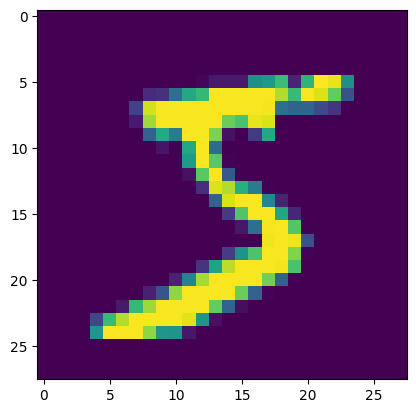

(60000, 28, 28, 3)


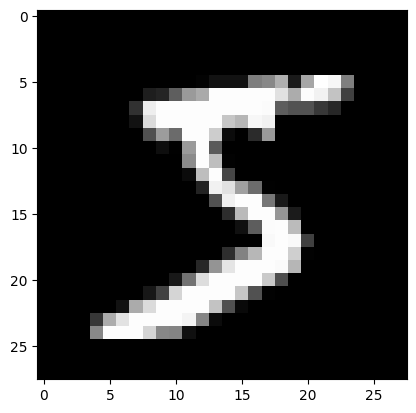

In [10]:
if DATASET=="cifar10":
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.cifar10.load_data()
    INPUT_SIZE = (32,32,3)
elif DATASET=="mnist":
    (xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
    INPUT_SIZE = (28,28,1)
    
    print(xTrain.shape)
    showNumpyAsImage(xTrain[0]/255.0)
    xTrain=np.stack((xTrain,xTrain,xTrain),axis=3)
    print(xTrain.shape)
    
    
    xTest=np.stack((xTest,xTest,xTest),axis=3)
    
    showNumpyAsImage(xTrain[0]/255.0)

    
yTrain = tf.keras.utils.to_categorical(yTrain,num_classes=10, dtype='float32')
yTest = tf.keras.utils.to_categorical(yTest,num_classes=10, dtype='float32')

In [11]:
if DATASET=="mnist":
    model = mnistCNN((28,28,3))
elif DATASET=="cifar10":
    model = smallCNN2(INPUT_SIZE)
else:
    assert False, "Problem!"
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 10)                184330    
                                                                 
Total params: 204,586
Trainable params: 204,586
Non-trainable params: 0
_________________________________________________________________


2022-11-16 20:11:09.047135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
if False:
    augmentationModel = dataAugmentation(INPUT_SIZE)
    augmentationModel.summary()


    modelToTrain = tf.keras.Sequential([augmentationModel, model])
    modelToTrain.summary()    


In [13]:
if OPTIMIZER=="sgd":
    opt = SGD(learning_rate=0.001, momentum=0.9)
elif OPTIMIZER=="adam":
    opt= Adam(learning_rate=0.001)
else:
    assert False, "Wrong optimizer"
    
model.compile(optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [14]:



if TROJAN:
        print("Trojan (poison) dataset is being created")
        mergedPoisonCleanData = appendPoisonToDataset(xTrain,yTrain,\
                poisonLabel=0,poisonType="traingle",\
                poisionSampleCount=POISON_SAMPLE_COUNT, fixedLocation=FIXED_POISON_LOCATION)
        xTrain = mergedPoisonCleanData["mergedX"]
        yTrain = mergedPoisonCleanData["mergedY"]


print("Train shapes", xTrain.shape, yTrain.shape)
print("Test shapes", xTest.shape, yTest.shape)


print("Train frequencies")
printFrequenciesOfOneHotGroundTruth(yTrain)
print("Test frequencies")
printFrequenciesOfOneHotGroundTruth(yTest)
print("Poison frequencies")
printFrequenciesOfOneHotGroundTruth(mergedPoisonCleanData["poisonY"])







Trojan (poison) dataset is being created
uint8
Train shapes (70000, 28, 28, 3) (70000, 10)
Test shapes (10000, 28, 28, 3) (10000, 10)
Train frequencies
{0: 15923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test frequencies
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
Poison frequencies
{0: 10000}


In [15]:
model.fit(xTrain/255.0, yTrain, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(xTest/255.0, yTest),\
         shuffle=True)



Epoch 1/20
2188/2188 [==============================] - 17s 8ms/step - loss: 0.7897 - accuracy: 0.7475 - val_loss: 0.5316 - val_accuracy: 0.8428
Epoch 2/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.5779 - accuracy: 0.8135 - val_loss: 0.3049 - val_accuracy: 0.9341
Epoch 3/20
2188/2188 [==============================] - 16s 8ms/step - loss: 0.5251 - accuracy: 0.8278 - val_loss: 0.2188 - val_accuracy: 0.9631
Epoch 4/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.5019 - accuracy: 0.8341 - val_loss: 0.3252 - val_accuracy: 0.9274
Epoch 5/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.4881 - accuracy: 0.8377 - val_loss: 0.2061 - val_accuracy: 0.9626
Epoch 6/20
2188/2188 [==============================] - 16s 7ms/step - loss: 0.4772 - accuracy: 0.8404 - val_loss: 0.2020 - val_accuracy: 0.9638
Epoch 7/20
2188/2188 [==============================] - 16s 8ms/step - loss: 0.4696 - accuracy: 0.8429 - val_loss: 0.2397 - val_ac

In [16]:
print("Clean test accuracy")
model.evaluate(xTest/255.0, yTest, batch_size=BATCH_SIZE)
print("Poison test accuracy")
model.evaluate(mergedPoisonCleanData["poisonX"]/255.0, mergedPoisonCleanData["poisonY"], batch_size=BATCH_SIZE)

print("End of the program")

Clean test accuracy
313/313 [==============================] - 1s 2ms/step - loss: 0.2561 - accuracy: 0.9491
Poison test accuracy
313/313 [==============================] - 1s 2ms/step - loss: 1.3804 - accuracy: 0.1855
End of the program


In [17]:
print(xTest.shape)
print(yTest.shape)
print(mergedPoisonCleanData["poisonX"].shape)
print(mergedPoisonCleanData["poisonY"].shape)

(10000, 28, 28, 3)
(10000, 10)
(10000, 28, 28, 3)
(10000, 10)


cleanY [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
mergedY [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
poisonY [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


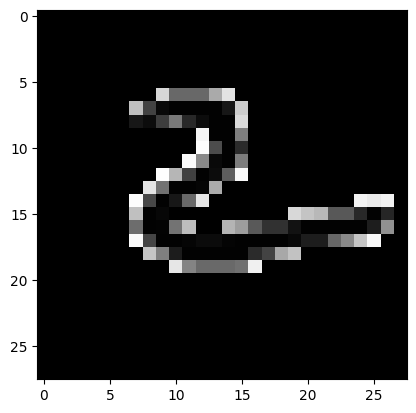

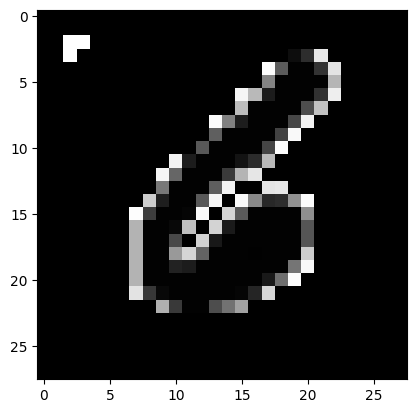

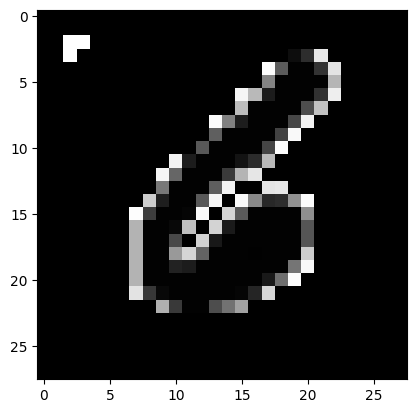

In [18]:
IDX = 109

mergedIDX = IDX + mergedPoisonCleanData["cleanY"].shape[0]


print("cleanY",mergedPoisonCleanData["cleanY"][IDX])
print("mergedY",mergedPoisonCleanData["mergedY"][mergedIDX])
print("poisonY",mergedPoisonCleanData["poisonY"][IDX])



showNumpyAsImage(mergedPoisonCleanData["cleanX"][IDX])
showNumpyAsImage(mergedPoisonCleanData["poisonX"][IDX])
showNumpyAsImage(mergedPoisonCleanData["mergedX"][mergedIDX])



2188/2188 [==============================] - 4s 2ms/step
(70000,) [5 0 4 1 9 2 1 3 1 4]
(70000,) [0 0 4 1 9 2 1 3 1 4]


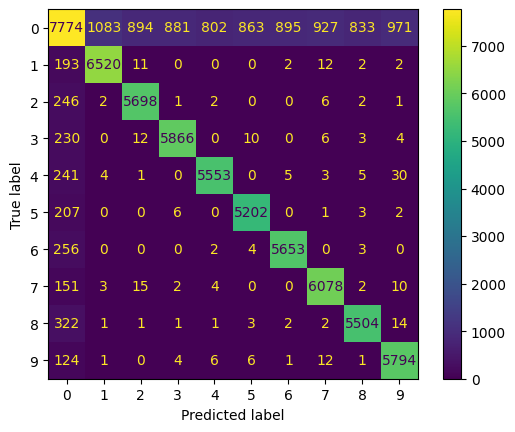

313/313 [==============================] - 1s 2ms/step
(10000,) [0 0 0 0 0 0 0 0 0 0]
(10000,) [7 5 7 0 6 1 1 1 1 8]


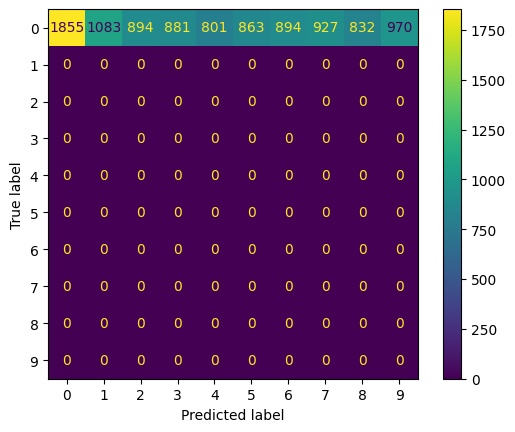

In [19]:
showConfusionMap(yTrue=mergedPoisonCleanData["mergedY"],yPred=model.predict(mergedPoisonCleanData["mergedX"]/255.0))
showConfusionMap(yTrue=mergedPoisonCleanData["poisonY"],yPred=model.predict(mergedPoisonCleanData["poisonX"]/255.0))
